In [240]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import os
from collections import defaultdict

import seaborn as sns
import matplotlib as plt
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint

In [2]:
%reload_ext dotenv
%dotenv -o

CITY_NAME = os.environ["CITY_NAME"]
CITY_SLUG = os.environ["CITY_SLUG"]
print(f"City name: {CITY_NAME}")
print(f"City slug: {CITY_SLUG}")

City name: Cambridge, MA, USA
City slug: cambridge_ma


## Read data

This shouldn't take longer than ~40 sec.

### Load graph, separate to nodes and edges

In [52]:
# ~15 sec
with open(f"./data/{CITY_SLUG}_networkx_graph.pkl", "rb") as fin:
    G = pickle.load(fin)

og_edges = list(G.edges)
for u, v, i in og_edges:
    if i > 0:
        G.remove_edge(u, v, i)
    
print(f"Graph has:")
print(f"  {G.number_of_nodes():,} nodes")
print(f"  {G.number_of_edges():,} edges")

Graph has:
  1,830 nodes
  4,092 edges


In [54]:
nodes, edges = ox.graph_to_gdfs(G)

In [203]:
def plot_base_network():
    fig, ax = plt.subplots()
    ox.plot_graph(
        G, ax=ax,
        figsize=(8, 8),
        bgcolor="#fff", edge_color="#000", node_color="#000",
        show=False, close=True,
        node_size=5, edge_linewidth=0.5
    )
    return fig, ax

### Load boba shop locations

In [159]:
# Hack from https://stackoverflow.com/questions/71907567/valueerror-geodataframe-does-not-support-multiple-columns-using-the-geometry-co
boba_gdf = gpd.read_file(f"./data/{CITY_SLUG}_boba_shops.csv",
                         GEOM_POSSIBLE_NAMES="geometry", 
                         KEEP_GEOM_COLUMNS="NO")
boba_gdf.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,location,phone,display_phone,distance,price,latitude,longitude,geometry
0,cNNTPEqz5uMY5cjCW7M8oA,tea-dō-central-sq-cambridge-3,Tea-Dō Central Sq,https://s3-media1.fl.yelpcdn.com/bphoto/-ie9cX...,False,https://www.yelp.com/biz/tea-d%C5%8D-central-s...,7,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...",5.0,"{'latitude': 42.363876, 'longitude': -71.100404}","['pickup', 'delivery']","{'address1': '425 Massachusetts Ave', 'address...",+16177508564,(617) 750-8564,1871.3516394194517,,42.363876,-71.100404,POINT (-71.10147 42.36408)
1,sKkCCr951o-wtPccNfPINw,mochinut-cambridgeside-cambridge-3,Mochinut - CambridgeSide,https://s3-media1.fl.yelpcdn.com/bphoto/_cbvL7...,False,https://www.yelp.com/biz/mochinut-cambridgesid...,2,"[{'alias': 'donuts', 'title': 'Donuts'}, {'ali...",5.0,"{'latitude': 42.368031, 'longitude': -71.076336}","['pickup', 'delivery']","{'address1': '100 Cambridgeside Pl', 'address2...",+12134254888,(213) 425-4888,3169.927665737517,,42.368031,-71.076336,POINT (-71.07599 42.36878)
2,RzcDKKBkxy1JPCEFoGrV8A,gong-cha-cambridge,Gong Cha,https://s3-media4.fl.yelpcdn.com/bphoto/a7adXx...,False,https://www.yelp.com/biz/gong-cha-cambridge?ad...,47,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}]",3.0,"{'latitude': 42.368436, 'longitude': -71.076129}","['pickup', 'delivery']","{'address1': '100 Cambridgeside Pl', 'address2...",+18572423637,(857) 242-3637,3152.494197624249,$,42.368436,-71.076129,POINT (-71.07599 42.36878)
3,996jyfv8Q6yyxJDFb8x4qA,moge-tee-cambridge-cambridge,Moge Tee - Cambridge,https://s3-media4.fl.yelpcdn.com/bphoto/PGgabg...,False,https://www.yelp.com/biz/moge-tee-cambridge-ca...,27,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}]",3.5,"{'latitude': 42.36519568829169, 'longitude': -...",[],"{'address1': '605 Massachusetts Ave', 'address...",+16177143891,(617) 714-3891,1641.7105503046705,$$,42.36519568829169,-71.10293830212905,POINT (-71.10298 42.36517)
4,RFMiG4t35kNr4Iz3ndu3nw,dado-tea-cambridge-2,Dado Tea,https://s3-media2.fl.yelpcdn.com/bphoto/iI-_D2...,False,https://www.yelp.com/biz/dado-tea-cambridge-2?...,177,"[{'alias': 'bubbletea', 'title': 'Bubble Tea'}...",4.0,"{'latitude': 42.369155, 'longitude': -71.1098279}",['delivery'],"{'address1': '955 Massachusetts Ave', 'address...",+16174979061,(617) 497-9061,1035.7653512403247,$,42.369155,-71.1098279,POINT (-71.11007 42.36911)


### Generate intersections of nearest boba shops

In [56]:
nodes.head(1)

,y,x,highway,street_count,geometry
osmid,,,,,
61182955,42.385184,-71.116133,traffic_signals,4,POINT (-71.11613 42.38518)


In [105]:
end_nodes = set()

for _, row in boba_gdf.iterrows():
    x, y = row["geometry"].x, row["geometry"].y
    node = ox.nearest_nodes(G, x, y)
    end_nodes.add(node)
    for edge in G.in_edges(node):
        end_nodes.add(edge[0])

end_nodes = list(end_nodes)

In [106]:
print(len(end_nodes), len(boba_gdf))

40 13


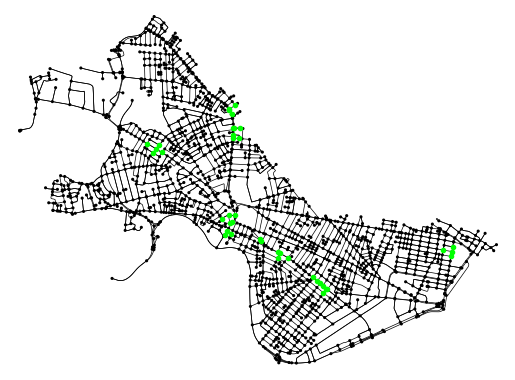

In [107]:
# Select rows of dataframe that match with endpoints
end_gdf = nodes.loc[end_nodes]

fig, ax = plot_base_network()
ax.plot(end_gdf["geometry"].x, end_gdf["geometry"].y, "o", markersize=3, c="#0f0")
fig

### Generate adjacency list

In [108]:
print("Imputing edge speeds...")
ox.speed.add_edge_speeds(G, hwy_speeds=(60 * 1.60934), fallback=(25 * 1.60934))
print("Imputing edge travel times...")
ox.speed.add_edge_travel_times(G)
print("Done.")

Imputing edge speeds...


Imputing edge travel times...
Done.


In [165]:
adj = defaultdict(list)
for u, v in tqdm(G.edges()):
    data = G.get_edge_data(u, v)[0]
    adj[u].append((v, data["travel_time"], round(data["length"], 3)))

100%|██████████| 4092/4092 [00:00<00:00, 59548.37it/s]


In [166]:
pprint(list(adj.items())[:10])

[(61182955, [(61323200, 10.7, 94.759)]),
 (61283119,
  [(61283126, 9.5, 105.188),
   (61321743, 12.2, 136.016),
   (61283322, 4.0, 44.369)]),
 (61283126,
  [(61321144, 9.3, 102.839),
   (61331850, 12.1, 134.05),
   (61283315, 3.9, 42.837)]),
 (61283218,
  [(61324632, 40.7, 451.723),
   (61283269, 81.9, 833.056),
   (61317302, 10.9, 110.483)]),
 (61283269,
  [(61321312, 24.1, 267.798),
   (6100432137, 44.9, 498.673),
   (61283218, 81.9, 833.056),
   (61323022, 10.7, 118.678)]),
 (61283273,
  [(61283287, 18.0, 160.366),
   (61283333, 9.5, 84.668),
   (61283340, 8.2, 73.034)]),
 (61283287, [(61321748, 10.9, 72.806)]),
 (61283293, [(568218971, 0.8, 12.929), (61283311, 5.7, 62.978)]),
 (61283300, [(61283287, 6.8, 75.455)]),
 (61283305, [(61317713, 6.2, 68.351), (61283345, 6.6, 73.176)])]


In [167]:
# Color nodes based on their travel times as a santify check
edge_times = list(nx.get_edge_attributes(G, "time").values())

def float_to_hex_color(float_list, colormap="viridis"):
    norm = plt.Normalize(min(float_list), max(float_list))
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=colormap)

    hex_colors = [mcolors.to_hex(mapper.to_rgba(value)) for value in float_list]
    return hex_colors

edge_colors = float_to_hex_color(edge_times)

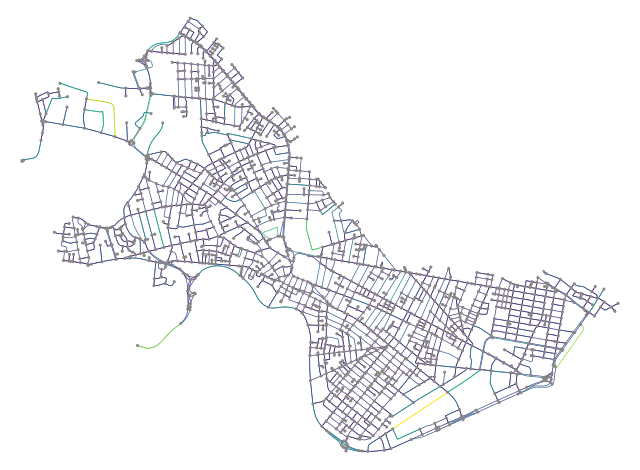

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [168]:
ox.plot_graph(
    G,
    figsize=(8, 8),
    bgcolor="#fff", edge_color=edge_colors, node_color="#888",
    node_size=5, edge_linewidth=0.5
)

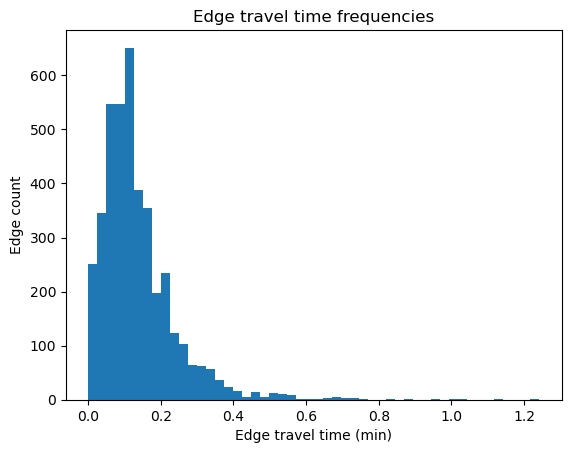

In [114]:
plt.xlabel("Edge travel time (min)")
plt.ylabel("Edge count")
plt.title("Edge travel time frequencies")
plt.hist(edge_times, bins=50);

## Generating random walks

In [100]:
import random

In [249]:
# Keep visiting nodes till we hit something in end_nodes
def random_walk(start, timeout=60*60*24):
    """
    Do a random walk starting from node <start> (node id)
        until we hit a boba shop, time out, or hit a dead end.

    Timeout is in seconds. If we haven't reached a boba shop or
        a dead end by that time, we terminate.
    
    Returns an ordered tuple:
        [0] route:        list of tuples (node id, time)
        [1] total_time:   float, end time
        [2] total_dist:   float, distance travelled
        [3] flag:         "success", "timeout", or "deadend"
    """
    cur = start
    route = []
    cur_time = 0
    cur_dist = 0

    while True:
        route.append((cur, cur_time))

        if cur in end_nodes:  # Found a boba shop!
            return route, cur_time, cur_dist, "success"
        if cur_time >= timeout:  # Time exceeded
            return route, cur_time, cur_dist, "timeout"
        if len(adj[cur]) == 0:  # Dead end
            return route, cur_time, cur_dist, "deadend"

        # Select a random neighbor to walk to
        nbr, t, dist = random.choices(adj[cur], k=1)[0]
        cur_time += t
        cur_dist += dist
        cur = nbr

In [250]:
def random_walks(start, n_walks=1000, flag_filter="success", timeout=60*60*24, verbose=False):
    """
    Do a lot of random walks. Only accept those with flag <filter>, unless
        <filter> is None, in which case we accept everything.
    """
    res = []

    iterable = tqdm(range(n_walks)) if verbose else range(n_walks)
    for _ in iterable:
        walk = random_walk(start, timeout)
        if flag_filter != None and walk[-1] != flag_filter:
            continue

        res.append(walk)

    return list(zip(*res))

In [234]:
startY, startX = ox.geocoder.geocode("MIT, MA, USA")
start = ox.nearest_nodes(G, startX, startY)

print(f"Starting at osmid={start}:")
print(nodes.loc[start])

print(f"\n{nodes.loc[start].y}, {nodes.loc[start].x}")

Starting at osmid=61327823:
y                                    42.357233
x                                    -71.09509
highway                                    NaN
street_count                                 3
geometry        POINT (-71.0950896 42.3572332)
Name: 61327823, dtype: object

42.3572332, -71.0950896


In [235]:
walks = random_walks(start, n_walks=1000, verbose=True)
routes = walks[2]

100%|██████████| 1000/1000 [00:03<00:00, 294.86it/s]


Walking from Harvard...


100%|██████████| 100/100 [00:00<00:00, 2052.87it/s]

Walking from MIT...


100%|██████████| 100/100 [00:00<00:00, 536.81it/s]


Walking from Alewife Station...


100%|██████████| 100/100 [00:00<00:00, 635.22it/s]


Walking from Cambridge Public Library...


100%|██████████| 100/100 [00:00<00:00, 1252.17it/s]


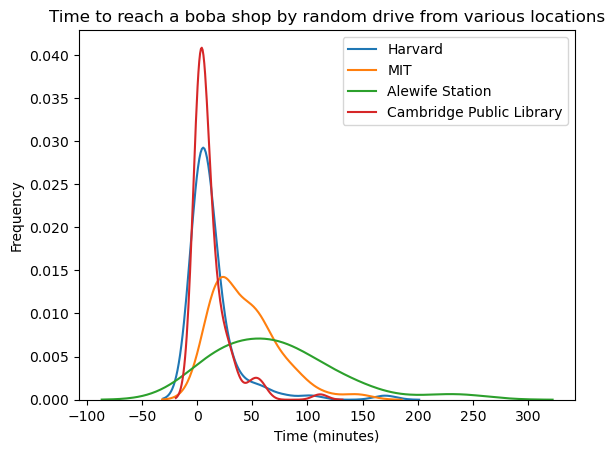

In [252]:
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")
plt.title("Time to reach a boba shop by random drive from various locations")

def boba_min_distr(placename):
    print(f"Walking from {placename}...")
    startY, startX = ox.geocoder.geocode(placename + ", MA, USA")
    start = ox.nearest_nodes(G, startX, startY)

    walks = random_walks(start, n_walks=100, verbose=True)
    time_mins = np.array(walks[1]) / 60

    sns.distplot(time_mins, hist=False, label=placename)

for place in ["Harvard", "MIT", "Alewife Station", "Cambridge Public Library"]:
    boba_min_distr(place)

plt.legend()

# plt.hist(time_mins[time_mins < 180], bins=50);

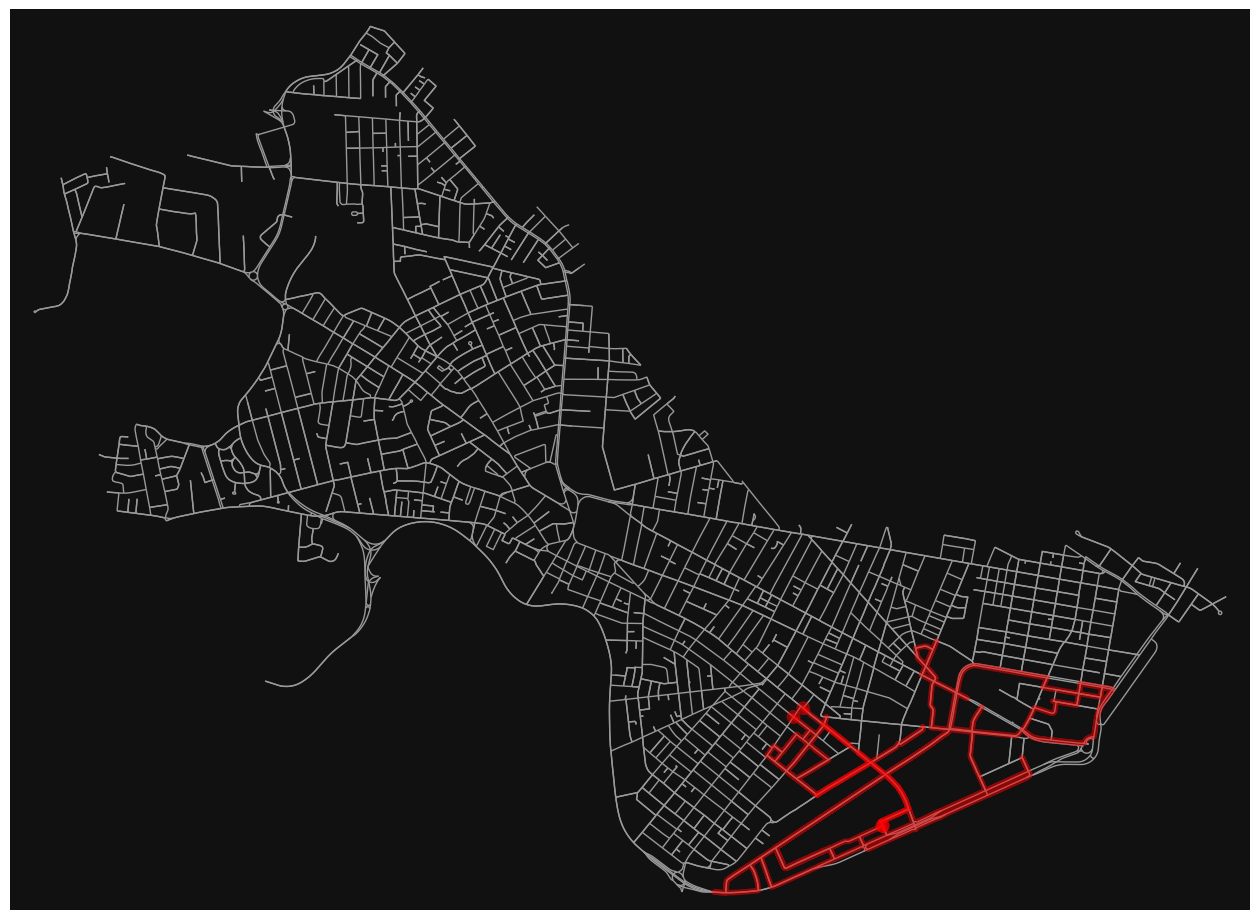

(<Figure size 1600x1600 with 1 Axes>, <Axes: >)

In [253]:
# Let's plot this
ox.plot.plot_graph_routes(
    G, [[p[0] for p in path] for path in walks[0][:2]], route_linewidth=0.1, route_alpha=0.5,
    figsize=(16, 16), node_size=0
)